In [1]:
# Handle imports

import math
import os
import datetime
import csv
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from bisect import bisect_left

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm_notebook as tqdm
from apex import amp
amp_handle = amp.init()

from IPython import display

In [3]:
# The Args object will contain all of our parameters
# If you want to run with different arguments, create another Args object

class Args(object):
  def __init__(self, name='cholec80', batch_size=64, test_batch_size=1000,
            epochs=10, lr=0.01/20, optimizer='adam', momentum=0.5,
            seed=1, log_interval=100, dataset='cholec80',
            video_dir='./videos', csv_dir="./tool_annotations/csv_annotations",
            model='DenseNetPretrainedFC', cuda=True, base_model="densenet", feature_extract=False,
            num_classes=7, pretrained=True):
    self.name = name # name for this training run. Don't use spaces.
    self.batch_size = batch_size
    self.test_batch_size = test_batch_size # Input batch size for testing
    self.epochs = epochs # Number of epochs to train
    self.lr = lr # Learning rate
    self.optimizer = optimizer # sgd/p1sgd/adam/rms_prop
    self.momentum = momentum # SGD Momentum
    self.seed = seed # Random seed
    self.log_interval = log_interval # Batches to wait before logging
                                     # detailed status. 0 = never
    self.progress_interval = log_interval // 10
    self.dataset = dataset # mnist/fashion_mnist
    self.video_dir = video_dir
    self.model = model
    self.base_model = base_model
    self.feature_extract = feature_extract
    self.num_classes = num_classes
    self.use_pretrained = pretrained
    self.cuda = cuda and torch.cuda.is_available()
    self.csv_dir = csv_dir

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True, use_cuda=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
       
    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [5]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_h, new_w))

        return img

In [6]:
# creating cholec80 dataset class

class cholec80(Dataset):
    def __init__(self, csv_dir, video_dir, transform=None, train=True):
        """
        Args: 
            csv_dir (string): Path to the directory with csv annotations.
            root_dir (string): Directory with all the videos.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_dir = csv_dir
        self.video_dir = video_dir
        self.transform = transform
        self.train = train
        self.filepath = os.path.join(csv_dir, "video_ends.csv")
        #hardcoding for testing purposes
        self.last_frame = None

    def __len__(self):
        if self.train:
            with open(self.filepath, "r") as f:
                reader = csv.reader(f)
                ends_list = list(reader)[0]
                length = int(ends_list[-17])
                return int(length/25)
        with open(self.filepath, "r") as f:
            reader = csv.reader(f)
            ends_list = list(reader)[0]
            lower_frame = int(ends_list[-17])/25
            higher_frame = int(ends_list[-1])/25
            return int(higher_frame - lower_frame)
                
        

    def __getitem__(self, idx):
        #idx is desired frame number
        if idx >= 0: idx += 1
        vid_no = None
        with open(self.filepath, "r") as f:
            reader = csv.reader(f)
            if self.train:
                # videos 1 to 64 are in the test set
                ends = list(map(int, list(reader)[0][:-16]))
                vid_no = bisect_left(ends, 25 * idx) + 1
                # need vid_no - 2 since ends is 0-indexed and we want prev video
                if vid_no == 1: self.last_frame = 0
                else: self.last_frame = ends[vid_no - 2]
            else:
                print("testing")
                ends = list(map(int, list(reader)[0][-17:]))
                last_train_frame = ends[0]
                ends = ends[1:]
                # videos 65 to 80 are in the test set
                vid_no = bisect_left(ends, 25 * idx + last_train_frame)
                if vid_no == 0: self.last_frame = 0
                else: self.last_frame = ends[vid_no - 1] - last_train_frame
                vid_no += 65
            
        label_file = os.path.join(self.csv_dir, "video" + str(vid_no) + "-tool.csv")
        if vid_no < 10:
            vid_name = os.path.join(self.video_dir, "video0" + str(vid_no) + ".mp4")
        else:
            vid_name = os.path.join(self.video_dir, "video" + str(vid_no) + ".mp4")

        cap = cv2.VideoCapture(vid_name)
        #last_frame is the last frame of the current video
        cap.set(cv2.CAP_PROP_POS_FRAMES, 25 * idx - self.last_frame)
        modIdx = int((25 * idx - self.last_frame) / 25)

        ret, image = cap.read()
        cap.release()
        label = None
        with open(label_file) as f:
            reader = csv.reader(f)
            all_frames = list(reader)
            entry = list(map(int, all_frames[modIdx - 1]))
            assert entry[0] == 25 * idx - self.last_frame, print(entry[0], 25 * idx, self.last_frame, vid_no)
            label = np.asarray(entry[1:]).astype(float)

        if self.transform:
            image = self.transform(image)
            
        sample = {'image': image, 'landmarks': label}

        return sample

In [7]:
def prepare_dataset(args):
    # choose the dataset
    if args.dataset == 'cholec80':
        DatasetClass = cholec80
        print("using cholec80")
    else:
        raise ValueError('unknown dataset: ' + args.dataset +
                ' try cholec80')

    def time_stamp(fname, fmt='%m-%d-%H-%M_{fname}'):
        return datetime.datetime.now().strftime(fmt).format(fname=fname)
        
    training_run_name = time_stamp(args.dataset + '_' + args.name)

    kwargs = {'num_workers': 16, 'pin_memory': True} if args.cuda else {}

    # Create the dataset: mnist or fasion_mnist
    dataset_dir = os.path.join(args.video_dir, args.dataset)
    training_run_dir = os.path.join(args.video_dir, training_run_name)
    
    train_dataset = DatasetClass(args.csv_dir, args.video_dir, train=True, transform=transforms.Compose([
            Rescale((224,224)), transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
    
    test_dataset = DatasetClass(args.csv_dir, args.video_dir, train=False, transform=transforms.Compose([
            Rescale((224,224)), transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    
    if not os.path.exists(training_run_dir):
        os.makedirs(training_run_dir)

    return train_loader, test_loader, train_dataset, test_dataset, training_run_dir

using cholec80
testing
testing
torch.Size([3, 224, 224])
[1. 0. 1. 0. 0. 0. 0.]


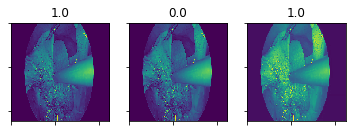

In [8]:
# visualize some images

args = Args()
_, _, _, test_dataset, _ = prepare_dataset(args)
images = test_dataset[5000]["image"]
labels = test_dataset[5000]["landmarks"]
print(images.shape)
print(labels)
fig, axes = plt.subplots(1,3)
for axis, img, lbl in zip(axes, images, labels):
    axis.imshow(img)
    axis.set_title(str(lbl))
    axis.set_yticklabels([])
    axis.set_xticklabels([])
plt.show()


In [9]:
def train(model, optimizer, train_loader, epoch, total_minibatch_count,
        train_losses, train_accs):
    # Training for a full epoch

    model.train()
    correct_count, total_loss, total_acc = 0., 0., 0.
    progress_bar = tqdm(train_loader, desc='Training')
    
    for batch_idx, entry in enumerate(progress_bar):
        data = entry["image"]
        target = entry["landmarks"]
        data, target = Variable(data), Variable(target)
        if args.cuda:
            data, target = data.cuda(), target.cuda()
            
        data, target = data.half(), target.half()

        optimizer.zero_grad()

        # Forward prediction step
        output = model(data)
        target = target
        
        loss_fn = nn.BCEWithLogitsLoss()
        loss = loss_fn(output, target)

        # Backpropagation step
        with amp_handle.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        #loss.backward()
        optimizer.step()

        # The batch has ended, determine the accuracy of the predicted outputs
        pred = output
        pred.data[pred.data >= 0.5] = 1
        pred.data[pred.data < 0.5] = 0
        
        matches = target == pred
        accuracy = matches.float().mean()
        
        total_loss += loss.data
        total_acc += accuracy.data
            
        if args.log_interval != 0 and total_minibatch_count % args.log_interval == 0:
            train_losses.append(loss.data)
            train_accs.append(accuracy.data)
       
        if args.progress_interval != 0 and total_minibatch_count % args.progress_interval == 0:
            progress_bar.set_description(
                'Epoch: {} loss: {:.4f}, acc: {:.2f}'.format(
                    epoch, total_loss / (batch_idx + 1), total_acc / (batch_idx + 1)))
            progress_bar.refresh()

        total_minibatch_count += 1

    return total_minibatch_count

In [10]:
def test(model, test_loader, epoch, total_minibatch_count,
        val_losses, val_accs):
    # Validation Testing
    model.eval()
    test_loss, correct = 0., 0.
    progress_bar = tqdm(test_loader, desc='Validation')
    loss_fn = nn.BCEWithLogitsLoss()
    with torch.no_grad():
        for entry in progress_bar:
            data = entry["image"]
            target = entry["landmarks"]
            data, target = Variable(data), Variable(target)
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            
            data, target = data.half(), target.half()
            output = model(data)
            target = target
            
            test_loss += loss_fn(output, target, reduction='sum').data  # sum up batch loss
            
            pred = output
            pred.data[pred.data >= 0.5] = 1
            pred.data[pred.data < 0.5] = 0
            correct += (target == pred).float().sum()

    test_loss /= len(test_loader.dataset)
    
    acc = correct / len(test_loader.dataset)

    val_losses.append(test_loss)
    val_accs.append(acc)
    
    progress_bar.clear()
    progress_bar.write(
        '\nEpoch: {} validation test results - Average val_loss: {:.4f}, val_acc: {}/{} ({:.2f}%)'.format(
            epoch, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    return acc

In [11]:
# Run the experiment
def run_experiment(args):

    total_minibatch_count = 0

    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)

    train_loader, test_loader, _, _, run_path = prepare_dataset(args)

    epochs_to_run = args.epochs

    # Initialize the model for this run
    model, input_size = initialize_model(args.base_model, args.num_classes, args.feature_extract, args.use_pretrained)
    
    #model.half()  # convert to half precision
    #for layer in model.modules():
    #    if isinstance(layer, nn.BatchNorm2d):
    #        layer.float()

    if args.cuda:
        model.cuda()

    # Choose optimizer
    if args.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    elif args.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif args.optimizer == 'rms_prop':
        optimizer = optim.RMSprop(model.parameters())
    else:
        raise ValueError('Unsupported optimizer: ' + args.optimizer)

    # Run the primary training loop, starting with validation accuracy of 0
    val_acc = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(1, epochs_to_run + 1):
        
        # train for 1 epoch
        total_minibatch_count = train(model, optimizer, train_loader,
                                    epoch, total_minibatch_count,
                                    train_losses, train_accs)
        # validate progress on test dataset
        val_acc = test(model, test_loader, epoch, total_minibatch_count,
                       val_losses, val_accs)
        
        torch.save(model.state_dict(), 'ultimate_model.pt')
        
    fig, axes = plt.subplots(1,4, figsize=(13,4))
    # plot the losses and acc
    plt.title(args.name)
    axes[0].plot(train_losses)
    axes[0].set_title("Loss")
    axes[1].plot(train_accs)
    axes[1].set_title("Acc")
    axes[2].plot(val_losses)
    axes[2].set_title("Val loss")
    axes[3].plot(val_accs)
    axes[3].set_title("Val Acc")
    
    # Write to csv file
    with open(os.path.join(run_path + 'train.csv'), 'w') as f:
        csvw = csv.writer(f, delimiter=',')
        for loss, acc in zip(train_losses, train_accs):
            csvw.writerow((loss, acc))

    # Predict and Test
    images, labels = next(iter(test_loader))
    if args.cuda:
        images, labels = images.cuda(), labels.cuda()
    output = model(images)
    #predicted = torch.max(output, 1)[1]
    fig, axes = plt.subplots(1,6)
    for i, (axis, img, lbl) in enumerate(zip(axes, images, output)):
        if i > 5:
            break
        img = img.permute(1,2,0).squeeze()
        axis.imshow(img)
        axis.set_title(str(lbl.data))
        axis.set_yticklabels([])
        axis.set_xticklabels([])
            
    if args.dataset == 'fashion_mnist' and val_acc > 0.92 and val_acc <= 1.0:
        print("Congratulations, you beat the Question 13 minimum of 92"
            "with ({:.2f}%) validation accuracy!".format(val_acc))

In [12]:
#%%capture output
run_experiment(Args())

using cholec80


/home/hagger/.virtualenvs/dt_train/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


KeyboardInterrupt: 

In [ ]:
ultimate_fashion_model = P2Q13UltimateNet()
ultimate_fashion_model.load_state_dict(torch.load('ultimate_model.pt'))
ultimate_fashion_model.eval()

train_loader, test_loader, _, _, run_path = prepare_dataset(args)
val_acc = test(ultimate_fashion_model, test_loader, 0, total_minibatch_count=0, val_losses=[], val_accs=[])

# Predict and Test
images, labels = next(iter(test_loader))
if args.cuda:
    images, labels = images.cuda(), labels.cuda()
output = ultimate_fashion_model(images)
predicted = torch.max(output, 1)[1]
fig, axes = plt.subplots(1,6)
for i, (axis, img, lbl) in enumerate(zip(axes, images, predicted)):
    if i > 5:
        break
    img = img.permute(1,2,0).squeeze()
    axis.imshow(img)
    axis.set_title(str(lbl.data))
    axis.set_yticklabels([])
    axis.set_xticklabels([])

In [ ]:
output.show()